# ML model in pytorch:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip uninstall shapely
! pip install shapely --no-binary shapely

     |████████████████████████████████| 10.8 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 56.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 56.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 72.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.5 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516294 sha256=f33f5d768603c73c99bb3f1d86378f9edd5d0b6600022905f5a4f95517b60c72
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |███

### Imports:

In [ ]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up CUDA:

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [ ]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
# Import custom scripts
#sys.path.append('../')
from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [ ]:
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt

Updated property [core/project].
Copying gs://ee-downscalingclimatemodels/test.txt...
/ [1 files][   13.0 B/   13.0 B]                                                
Operation completed over 1 objects/13.0 B.                                       
AIAIAIAIAIAIA

## Load data:

### (Input) Global climate model:

In [ ]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be rem

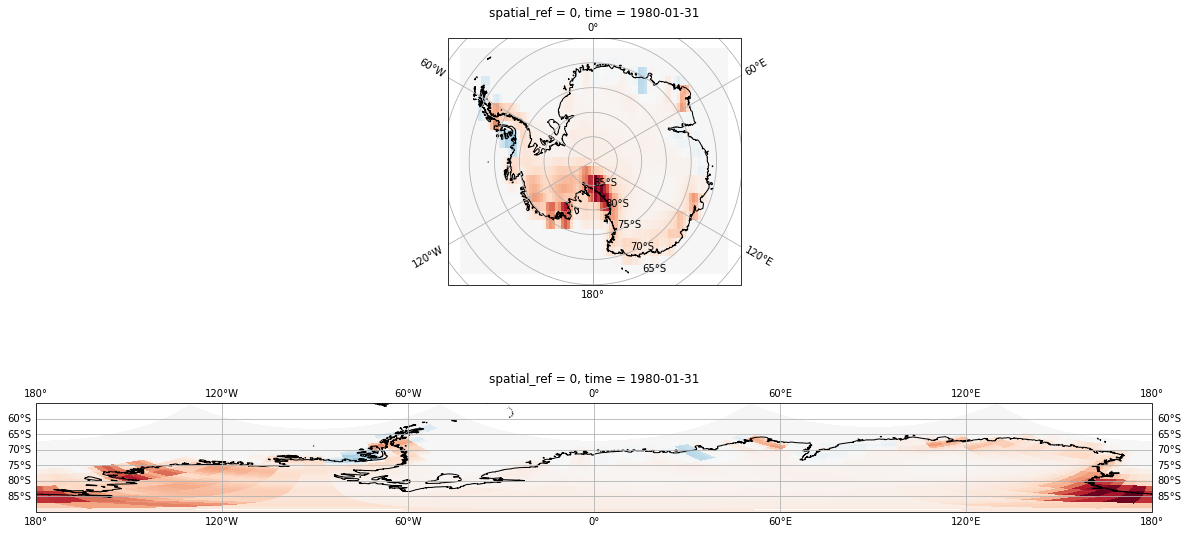

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Target) Regional climate model:

In [ ]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    target_dataset = xr.open_dataset(pathCluster + fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))


## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [ ]:
# Download GMC like RCM input data:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)

if REGION == "Combined":
    inputs_2D = []
    inputs_1D = []
    inputs_2D_ns = []
    inputs_1D_ns = []
    i = 0
    for r in REGIONS:
        i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
        inputs_1D.append(i1D)
        inputs_2D.append(i2D)
        inputs_1D_ns.append(i1D_ns)
        inputs_2D_ns.append(i2D_ns)
        i+=1
else:
    i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike, SIZE_INPUT_DOMAIN, Region=REGION, regionNbr = 0
    )
    inputs_2D_ns = [i2D_ns]
    inputs_1D_ns = [i1D_ns]
    inputs_2D = [i2D]
    inputs_1D = [i1D]
    REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

### Target:

In [ ]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 7)
Input 1D: (1452, 1, 1, 17)


### Example of each region of Antarctica:
Plot an example of each region that is used.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


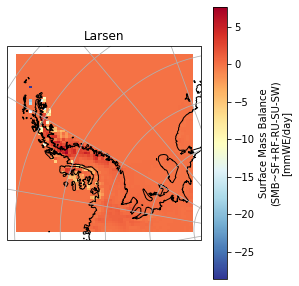

In [ ]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Examples of input to model:
Show an example of process of how dataset is

2D Feature batch shape: torch.Size([32, 7, 32, 32])
1D Feature batch shape: torch.Size([32, 17, 1, 1])
Labels batch shape: torch.Size([32, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

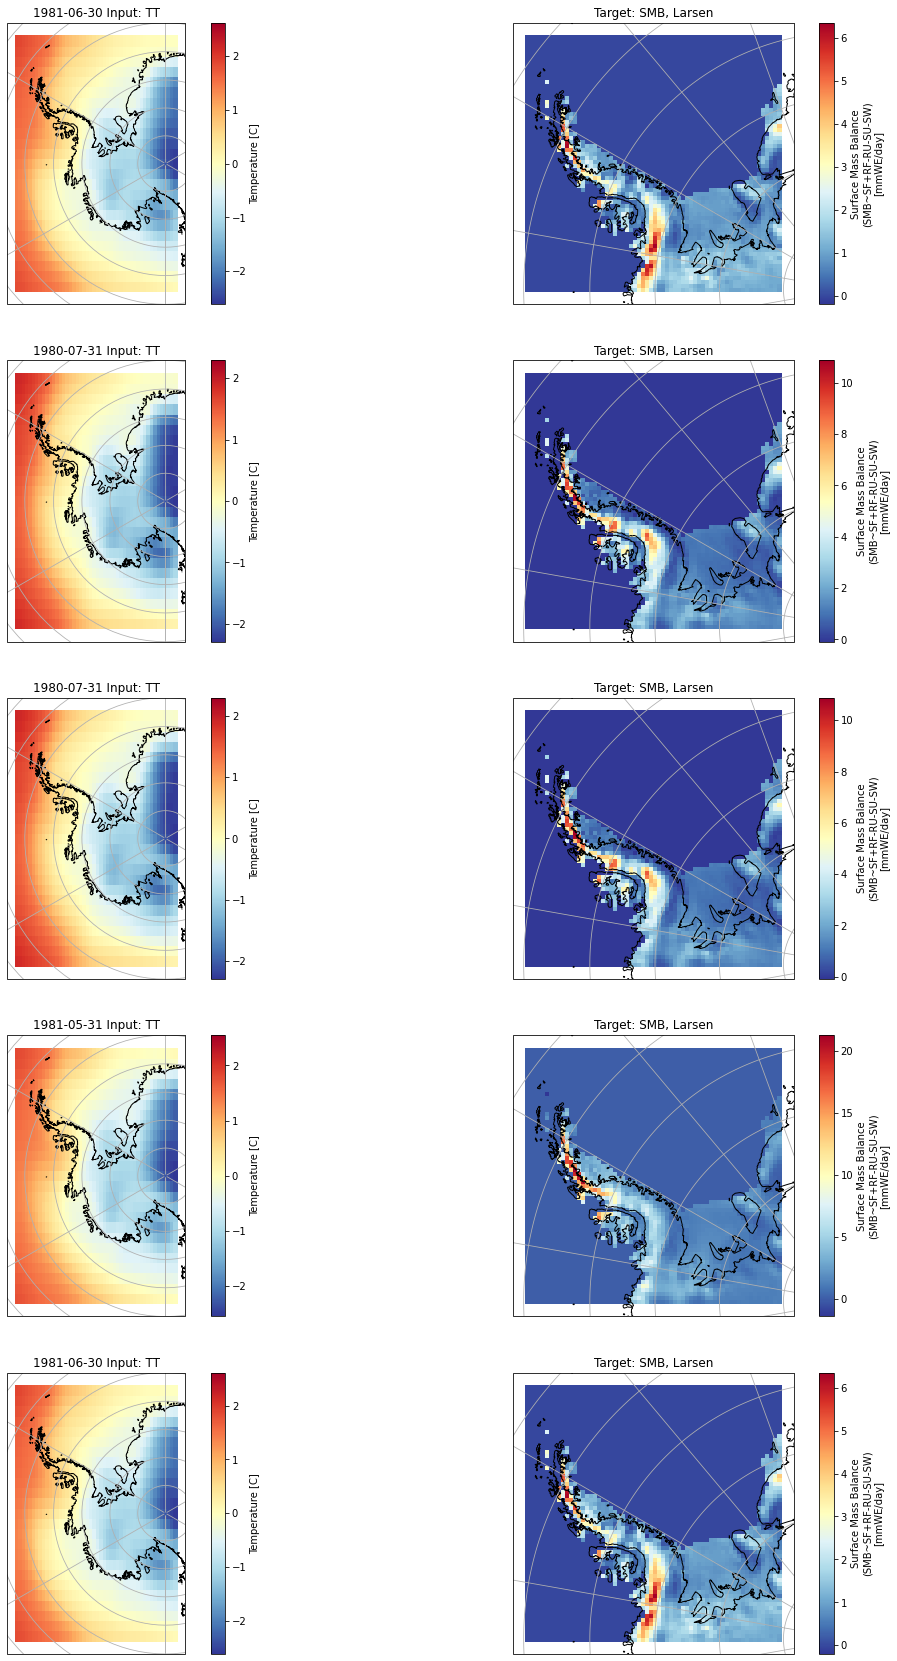

In [ ]:
#  Create pytorch tensors:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION) # region encoder
X.shape, Z.shape, Y.shape, len(R)

# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

### Architecture:

In [ ]:
# import architecture from py files
from unet import *

In [ ]:
# Test of U-Net:
n_channels_x = 7
n_channels_z = 17
size = 32
filter = 64

unet = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

train_X, train_Z, train_Y, train_R = next(iter(train_loader))
x = unet(train_X, train_Z)
x.shape, train_X.shape, train_Z.shape, train_R.shape

(torch.Size([32, 1, 64, 64]),
 torch.Size([32, 7, 32, 32]),
 torch.Size([32, 17, 1, 1]),
 torch.Size([32]))

## Training

In [ ]:
# Load configuration file:
from config import *
from dataFunctions import *
from training_functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def trainFlow(full_input, 
              full_target, 
              region: str = REGION, 
              test_percent: float = TEST_PERCENT, 
              val_percent: float = VAL_PERCENT,
              seed: int = SEED, 
              num_epochs: int = NUM_EPOCHS, 
              batch_size: int = BATCH_SIZE, 
              lr: float = LR, 
              amp: bool = AMP, 
              train: bool = True):
  
  num_epochs = trainingParam['num_epochs']
  seed = trainingParam['seed']
  batch_size = trainingParam['batch_size']
  lr = trainingParam['lr']
  amp = trainingParam['amp']
  
  # start logging
  logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  logging.info(f"Using device {device}")

  # Build U-Net
  n_channels_x = 7
  n_channels_z = 17
  size = 32
  filter = 64

  dir_checkpoint = Path("./checkpoints/")

  net = UNetMarijn(
      n_channels_x=n_channels_x,
      n_channels_z=n_channels_z,
      size=size,
      filter=filter,
      bilinear=False,
  )

  logging.info(
      f"Network:\n"
      f"\t{net.n_channels_x} input channels X\n"
      f"\t{net.n_channels_z} input channels Z\n"
      f"\t{net.size} size\n"
      f"\t{net.filter} filter\n"
      f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling'
  )

  # if load model from .pth file
  load = False  # type=str, default=False, Load model from a .pth file
  if load:  # Load model from a .pth file
      net.load_state_dict(torch.load(load, map_location=device))
      logging.info(f"Model loaded from {load}")
  
  net.to(device=device) # send to cuda
  
  # 1. Create dataset:
  X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
  Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
  Y = torch.tensor(full_target.transpose(0, 3, 1, 2))

  # Indicator of regions and their order if combined dataset
  # Encoding 0-> Num regions
  R = regionEncoder(X, region)

  # Create dataset:
  dataset = TensorDataset(X, Z, Y, R)

  # 2. Split into test and train/val set:
  n_test = int(len(dataset) * test_percent)
  n_train = len(dataset) - n_test
  logging.info(f"Test set size: {n_test}\n" f"Train set size: {n_train}\n")
  train_set, test_set = random_split(
      dataset, [n_train, n_test], generator=torch.Generator().manual_seed(seed)
  )

  # 3. Train
  if train:
    train_loss_e, val_loss_e = train_net(
            net=net,
            dataset=train_set,
            epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=lr,
            device=device,
            val_percent=val_percent,
            amp=amp,
            dir_checkpoint = Path("./checkpoints/"), 
            region = region)
    return train_loss_e, val_loss_e, train_set, test_set
  else:
    return train_set, test_set, net

### Scenario 1: 1 region

#### Larsen:

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *

In [ ]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)

In [ ]:
%%time
train_loss_e, val_loss_e, train_set, test_set = trainFlow(full_input, 
                                     full_target,
                                     region = REGION,
                                     train = True,
                                     **trainingParam)

In [ ]:
plotLoss(train_loss_e, val_loss_e)

##### Prediction:

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for pre_run_cell):


Exception: ignored

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Larsen_100_32.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

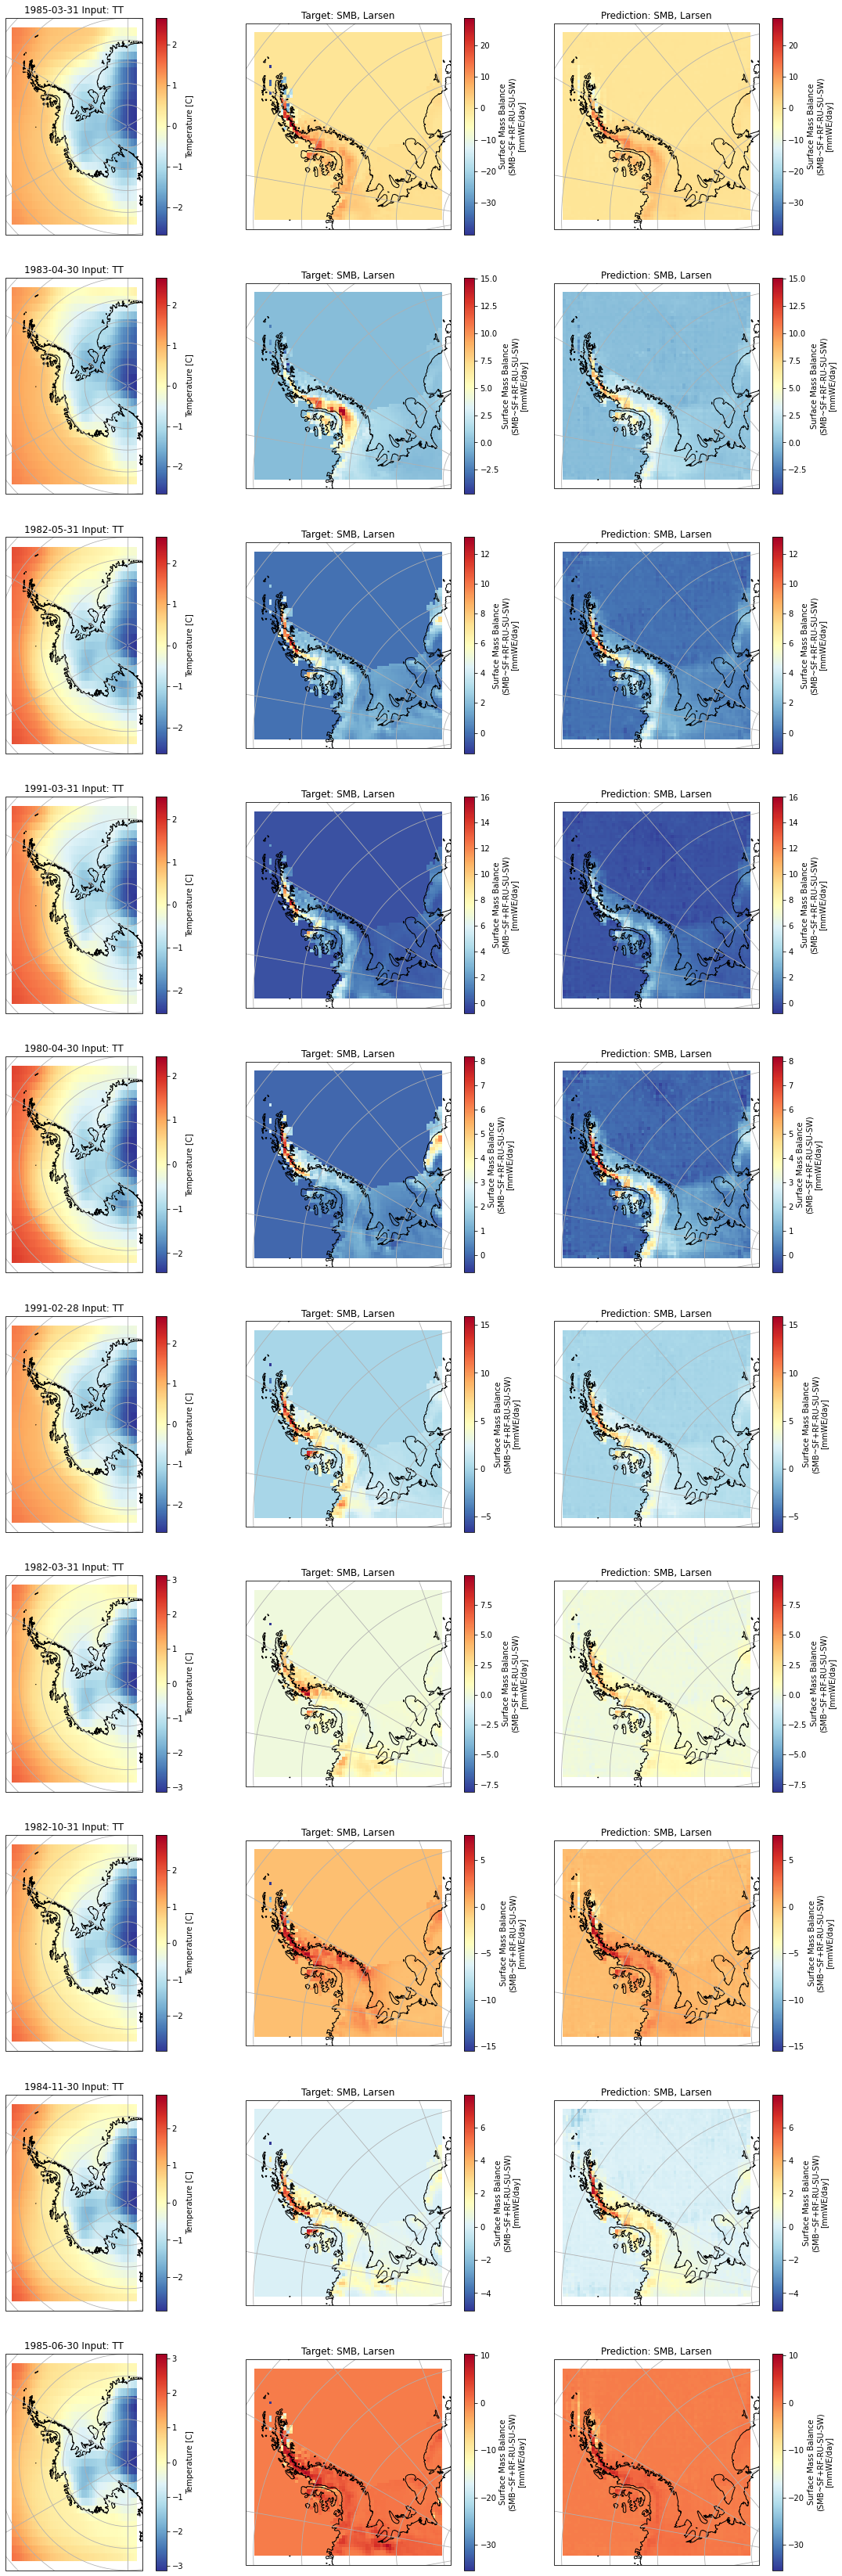

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for post_run_cell):


Exception: ignored

In [ ]:
from training_functions import *

REGION = "Larsen"

# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds, x, z, true_smb, r = predict(net, device, test_loader, model)
# plot predictions
plotRandomPredictions(
    preds,
    x,
    z,
    true_smb,
    r,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=[REGION],
    **trainingParam
)

##### Metrics:

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for pre_run_cell):


Exception: ignored

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

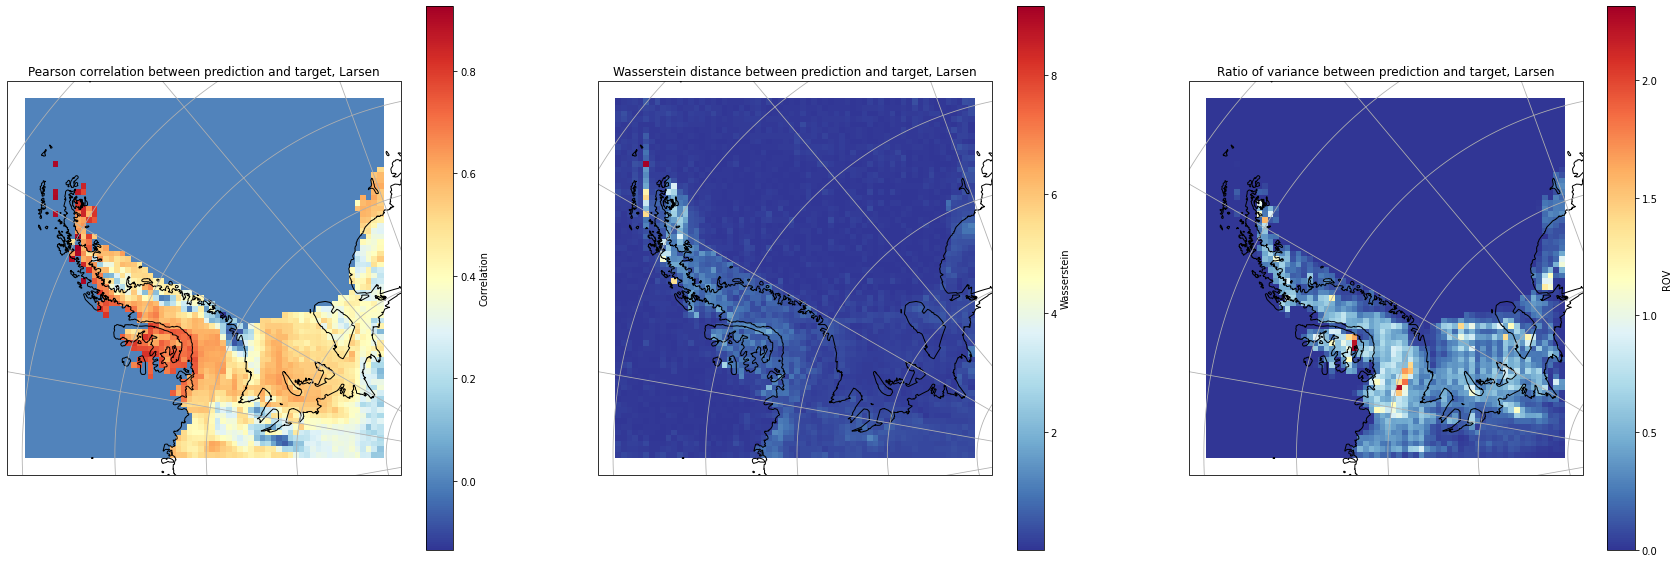

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for post_run_cell):


Exception: ignored

In [ ]:
from metrics import *

fig = plt.figure(figsize=(30, 10))

PearsonCorr = calculatePearson(preds, true_smb)
vmin, vmax = PearsonCorr.min(), PearsonCorr.max()
ax = plt.subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
plotPearsonCorr(target_dataset, PearsonCorr, ax, vmin, vmax, region="Larsen")

ax = plt.subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
Wasserstein = calculateWasserstein(preds, true_smb)
vmin, vmax = Wasserstein.min(), Wasserstein.max()
plotWasserstein(target_dataset, Wasserstein, ax, vmin, vmax, region="Larsen")

ax = plt.subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
ROV = calculateROV(preds, true_smb)
vmin, vmax = ROV.min(), ROV.max()
plotROV(target_dataset, ROV, ax, vmin, vmax, region="Larsen")

nameFig = f"{today}_metrics_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.png"
plt.savefig(nameFig)
files.download(nameFig)

#### Maud:

In [ ]:
REGION = "Maud"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for pre_run_cell):


Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f91104c33d0>> (for post_run_cell):


Exception: ignored

In [ ]:
%%time
train_loss_e, val_loss_e, train_set, test_set = trainFlow(full_input, 
                                     full_target,
                                     region = REGION,
                                     train = True,
                                     **trainingParam)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046



INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:16<00:00, 62.82timestep/s, loss (batch)=0.458]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.43timestep/s, loss (batch)=0.987]
INFO: Checkpoint 2 saved!
Epoch 3/100:  86%|████████▌ | 896/1046 [00:12<00:02, 58.24timestep/s, loss (batch)=0.552]

Epoch 00031: reducing learning rate of group 0 to 5.0000e-04.


Epoch 3/100: 100%|██████████| 1046/1046 [00:15<00:00, 67.62timestep/s, loss (batch)=0.26]
INFO: Checkpoint 3 saved!
Epoch 4/100:  98%|█████████▊| 1024/1046 [00:14<00:00, 73.49timestep/s, loss (batch)=0.256]

Epoch 00043: reducing learning rate of group 0 to 5.0000e-05.


Epoch 4/100: 100%|██████████| 1046/1046 [00:15<00:00, 65.95timestep/s, loss (batch)=0.369]
INFO: Checkpoint 4 saved!
Epoch 5/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.59timestep/s, loss (batch)=0.207]
INFO: Checkpoint 5 saved!
Epoch 6/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.86timestep/s, loss (batch)=0.265]
INFO: Checkpoint 6 saved!
Epoch 7/100: 100%|██████████| 1046/1046 [00:15<00:00, 67.43timestep/s, loss (batch)=0.268]
INFO: Checkpoint 7 saved!
Epoch 8/100: 100%|██████████| 1046/1046 [00:15<00:00, 65.71timestep/s, loss (batch)=0.338]
INFO: Checkpoint 8 saved!
Epoch 9/100:  86%|████████▌ | 896/1046 [00:12<00:02, 59.94timestep/s, loss (batch)=0.48] 

Epoch 00097: reducing learning rate of group 0 to 5.0000e-06.


Epoch 9/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.98timestep/s, loss (batch)=0.584]
INFO: Checkpoint 9 saved!
Epoch 10/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.94timestep/s, loss (batch)=0.192]
INFO: Checkpoint 10 saved!
Epoch 11/100: 100%|██████████| 1046/1046 [00:15<00:00, 67.28timestep/s, loss (batch)=0.274]
INFO: Checkpoint 11 saved!
Epoch 12/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.49timestep/s, loss (batch)=0.184]
INFO: Checkpoint 12 saved!
Epoch 13/100:  34%|███▎      | 352/1046 [00:04<00:09, 75.61timestep/s, loss (batch)=0.18]

Epoch 00135: reducing learning rate of group 0 to 5.0000e-07.


Epoch 13/100:  80%|███████▉  | 832/1046 [00:11<00:02, 72.60timestep/s, loss (batch)=0.193]

Epoch 00140: reducing learning rate of group 0 to 5.0000e-08.


Epoch 13/100: 100%|██████████| 1046/1046 [00:15<00:00, 68.06timestep/s, loss (batch)=0.218]
INFO: Checkpoint 13 saved!
Epoch 14/100:  24%|██▍       | 256/1046 [00:03<00:10, 73.81timestep/s, loss (batch)=0.299]

Epoch 00145: reducing learning rate of group 0 to 5.0000e-09.


Epoch 14/100: 100%|██████████| 1046/1046 [00:15<00:00, 66.93timestep/s, loss (batch)=0.453]
INFO: Checkpoint 14 saved!
Epoch 15/100: 100%|██████████| 1046/1046 [00:14<00:00, 72.44timestep/s, loss (batch)=0.2]
INFO: Checkpoint 15 saved!
Epoch 16/100: 100%|██████████| 1046/1046 [00:13<00:00, 75.46timestep/s, loss (batch)=0.339]
INFO: Checkpoint 16 saved!
Epoch 17/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.48timestep/s, loss (batch)=0.39]
INFO: Checkpoint 17 saved!
Epoch 18/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.57timestep/s, loss (batch)=0.339]
INFO: Checkpoint 18 saved!
Epoch 19/100: 100%|██████████| 1046/1046 [00:13<00:00, 78.19timestep/s, loss (batch)=0.675]
INFO: Checkpoint 19 saved!
Epoch 20/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.68timestep/s, loss (batch)=0.225]
INFO: Checkpoint 20 saved!
Epoch 21/100: 100%|██████████| 1046/1046 [00:13<00:00, 78.61timestep/s, loss (batch)=0.577]
INFO: Checkpoint 21 saved!
Epoch 22/100: 100%|██████████| 1046/1046 [00:13<00:

CPU times: user 12min 23s, sys: 11min 40s, total: 24min 4s
Wall time: 25min 58s


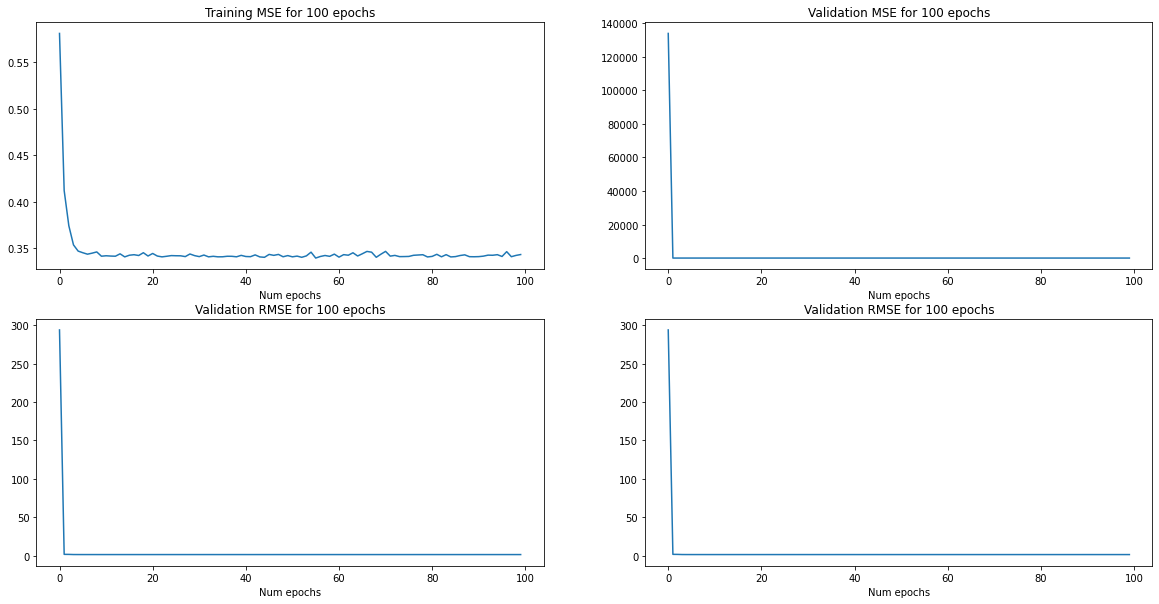

In [ ]:
plotLoss(train_loss_e, val_loss_e)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Maud_100_32.pth
INFO: Using device cuda
INFO: Saved model loaded!


['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud
['Maud'] Maud


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

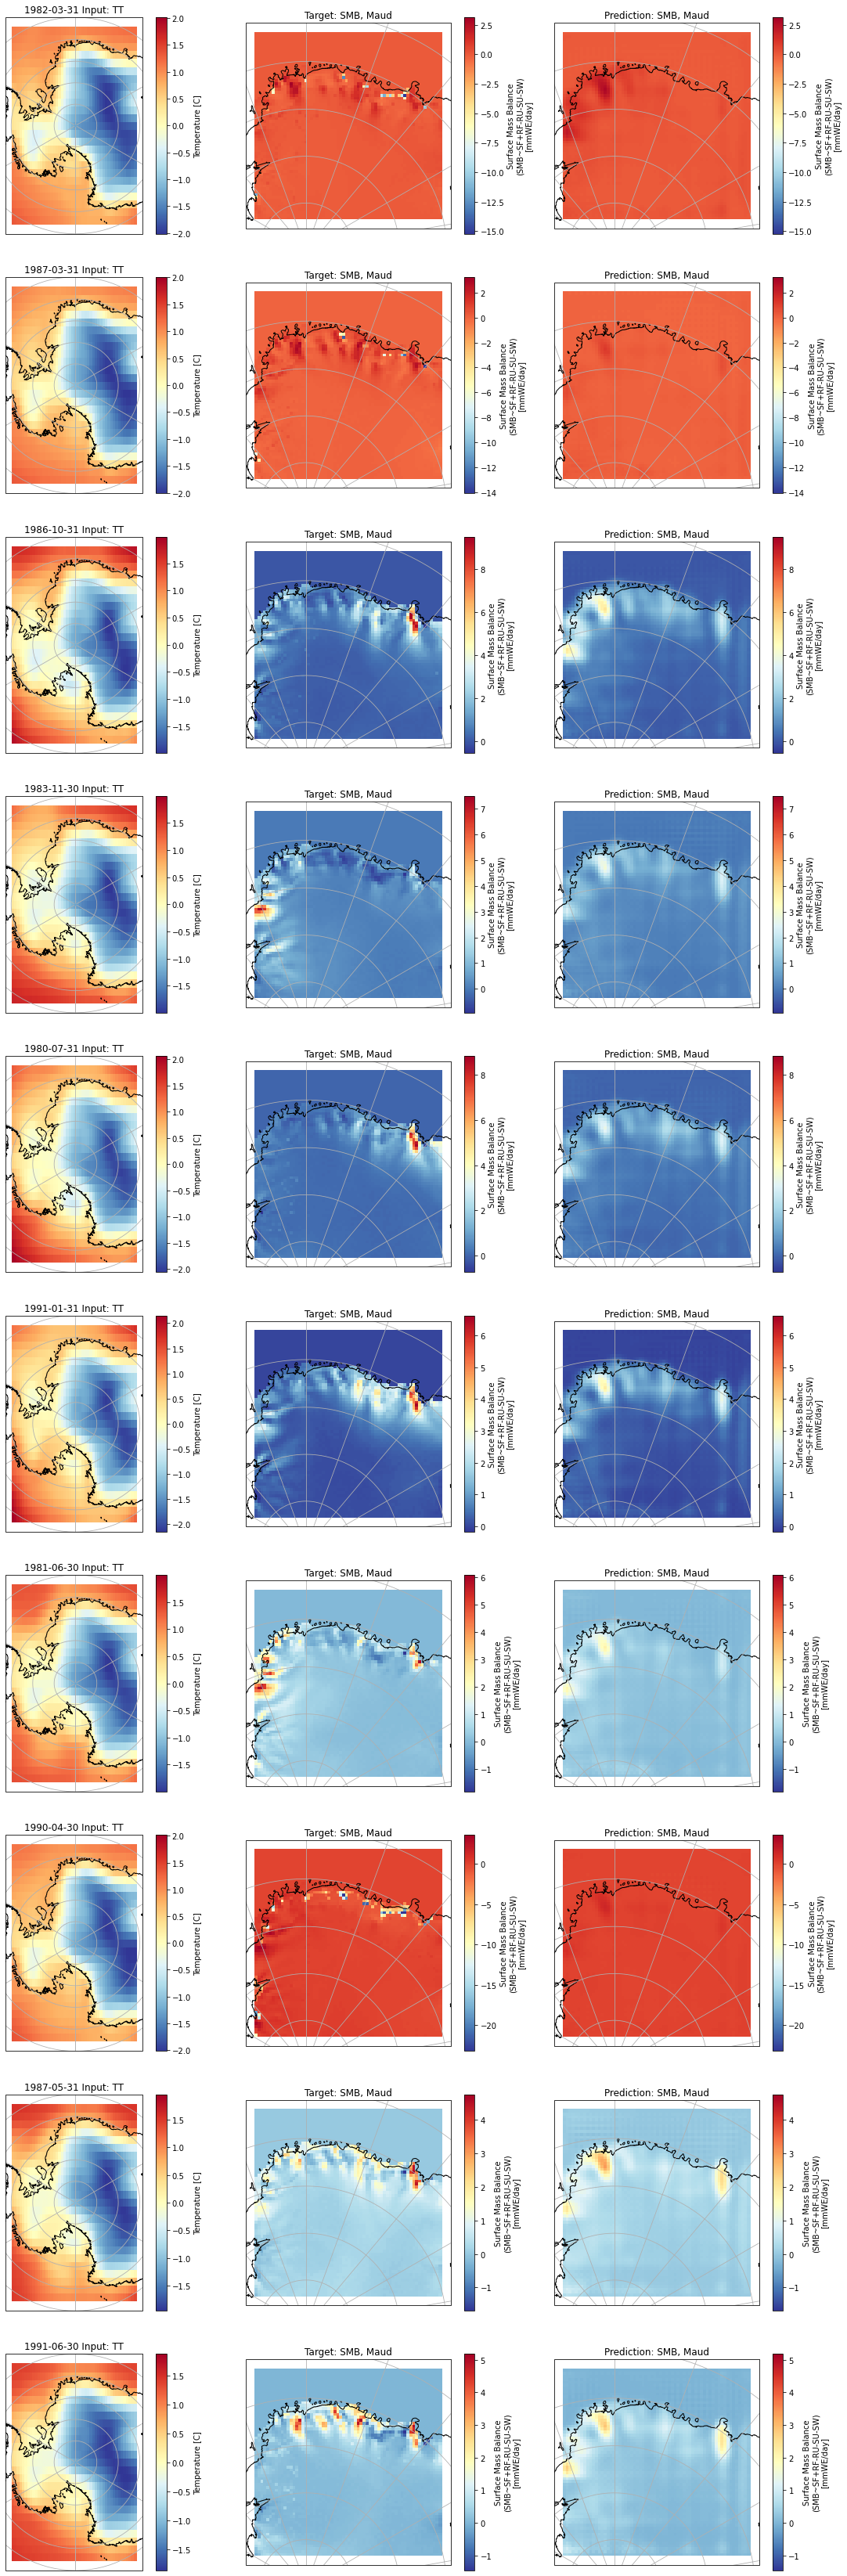

In [ ]:
from training_functions import *

REGION = "Maud"

# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds, x, z, true_smb, r = predict(net, device, test_loader, model)
# plot predictions
plotRandomPredictions(
    preds,
    x,
    z,
    true_smb,
    r,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=[REGION],
    **trainingParam
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

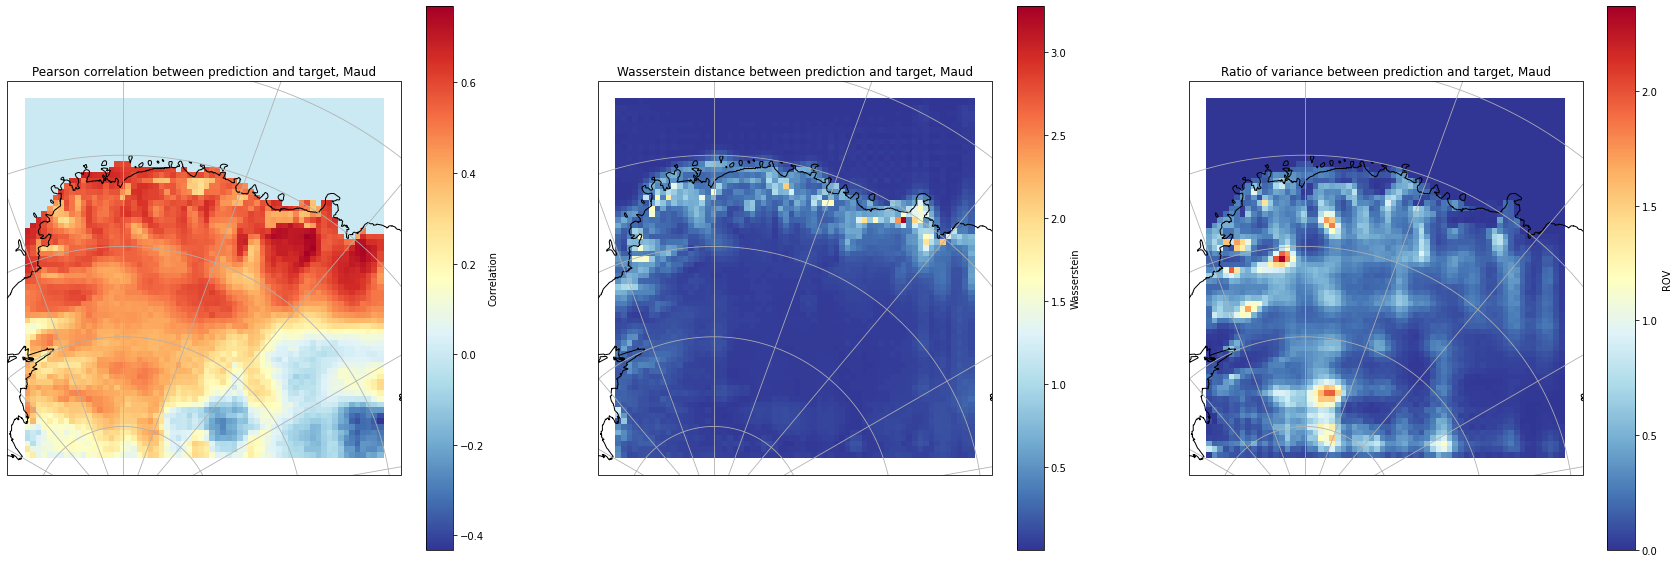

In [ ]:
from metrics import *

fig = plt.figure(figsize=(30, 10))

PearsonCorr = calculatePearson(preds, true_smb)
vmin, vmax = PearsonCorr.min(), PearsonCorr.max()
ax = plt.subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
plotPearsonCorr(target_dataset, PearsonCorr, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
Wasserstein = calculateWasserstein(preds, true_smb)
vmin, vmax = Wasserstein.min(), Wasserstein.max()
plotWasserstein(target_dataset, Wasserstein, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
ROV = calculateROV(preds, true_smb)
vmin, vmax = ROV.min(), ROV.max()
plotROV(target_dataset, ROV, ax, vmin, vmax, region=REGION)

nameFig = f"{today}_metrics_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.png"
plt.savefig(nameFig)
files.download(nameFig)

#### Wilkes

In [ ]:
REGION = "Wilkes"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)

In [ ]:
%%time
train_loss_e, val_loss_e, train_set, test_set = trainFlow(full_input, 
                                     full_target,
                                     region = REGION,
                                     train = True,
                                     **trainingParam)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046

wandb: Currently logged in as: anony-moose-249973 (use `wandb login --relogin` to force relogin)


INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.74timestep/s, loss (batch)=0.324]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:12<00:00, 82.62timestep/s, loss (batch)=0.491]
INFO: Checkpoint 2 saved!
Epoch 3/100: 100%|██████████| 1046/1046 [00:12<00:00, 83.49timestep/s, loss (batch)=0.165]
INFO: Checkpoint 3 saved!
Epoch 4/100:  95%|█████████▍| 992/1046 [00:11<00:00, 69.12timestep/s, loss (batch)=0.544]

Epoch 00043: reducing learning rate of group 0 to 5.0000e-04.


Epoch 4/100: 100%|██████████| 1046/1046 [00:12<00:00, 83.17timestep/s, loss (batch)=0.522]
INFO: Checkpoint 4 saved!
Epoch 5/100: 100%|██████████| 1046/1046 [00:12<00:00, 82.38timestep/s, loss (batch)=0.186]
INFO: Checkpoint 5 saved!
Epoch 6/100: 100%|██████████| 1046/1046 [00:12<00:00, 82.88timestep/s, loss (batch)=0.61]
INFO: Checkpoint 6 saved!
Epoch 7/100: 100%|██████████| 1046/1046 [00:12<00:00, 82.36timestep/s, loss (batch)=0.27]
INFO: Checkpoint 7 saved!
Epoch 8/100:  12%|█▏        | 128/1046 [00:01<00:12, 72.80timestep/s, loss (batch)=0.161]

Epoch 00078: reducing learning rate of group 0 to 5.0000e-05.


Epoch 8/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.12timestep/s, loss (batch)=0.567]
INFO: Checkpoint 8 saved!
Epoch 9/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.74timestep/s, loss (batch)=0.213]
INFO: Checkpoint 9 saved!
Epoch 10/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.77timestep/s, loss (batch)=0.619]
INFO: Checkpoint 10 saved!
Epoch 11/100:  40%|███▉      | 416/1046 [00:04<00:09, 68.60timestep/s, loss (batch)=0.192]

Epoch 00114: reducing learning rate of group 0 to 5.0000e-06.


Epoch 11/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.33timestep/s, loss (batch)=0.311]
INFO: Checkpoint 11 saved!
Epoch 12/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.27timestep/s, loss (batch)=0.548]
INFO: Checkpoint 12 saved!
Epoch 13/100: 100%|██████████| 1046/1046 [00:12<00:00, 80.54timestep/s, loss (batch)=0.782]
INFO: Checkpoint 13 saved!
Epoch 14/100:  49%|████▉     | 512/1046 [00:06<00:07, 68.39timestep/s, loss (batch)=0.24] 

Epoch 00148: reducing learning rate of group 0 to 5.0000e-07.


Epoch 14/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.31timestep/s, loss (batch)=0.192]
INFO: Checkpoint 14 saved!
Epoch 15/100:  12%|█▏        | 128/1046 [00:01<00:12, 71.00timestep/s, loss (batch)=0.276]

Epoch 00155: reducing learning rate of group 0 to 5.0000e-08.


Epoch 15/100:  58%|█████▊    | 608/1046 [00:07<00:06, 68.10timestep/s, loss (batch)=0.25] 

Epoch 00160: reducing learning rate of group 0 to 5.0000e-09.


Epoch 15/100: 100%|██████████| 1046/1046 [00:12<00:00, 81.03timestep/s, loss (batch)=0.16]
INFO: Checkpoint 15 saved!
Epoch 16/100: 100%|██████████| 1046/1046 [00:13<00:00, 80.15timestep/s, loss (batch)=0.196]
INFO: Checkpoint 16 saved!
Epoch 17/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.90timestep/s, loss (batch)=0.32]
INFO: Checkpoint 17 saved!
Epoch 18/100: 100%|██████████| 1046/1046 [00:13<00:00, 80.33timestep/s, loss (batch)=0.884]
INFO: Checkpoint 18 saved!
Epoch 19/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.82timestep/s, loss (batch)=0.303]
INFO: Checkpoint 19 saved!
Epoch 20/100: 100%|██████████| 1046/1046 [00:13<00:00, 80.28timestep/s, loss (batch)=0.178]
INFO: Checkpoint 20 saved!
Epoch 21/100: 100%|██████████| 1046/1046 [00:13<00:00, 80.05timestep/s, loss (batch)=0.308]
INFO: Checkpoint 21 saved!
Epoch 22/100: 100%|██████████| 1046/1046 [00:13<00:00, 79.44timestep/s, loss (batch)=0.581]
INFO: Checkpoint 22 saved!
Epoch 23/100: 100%|██████████| 1046/1046 [00:13<00

CPU times: user 17min 14s, sys: 8min 41s, total: 25min 55s
Wall time: 25min 48s


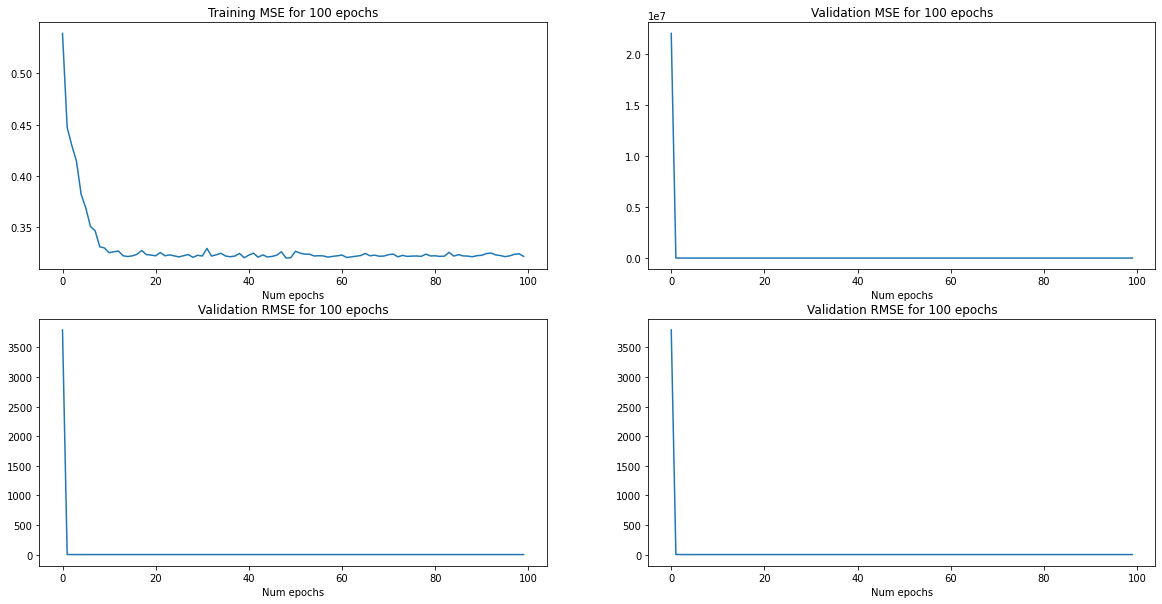

In [ ]:
plotLoss(train_loss_e, val_loss_e)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Wilkes_100_32.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

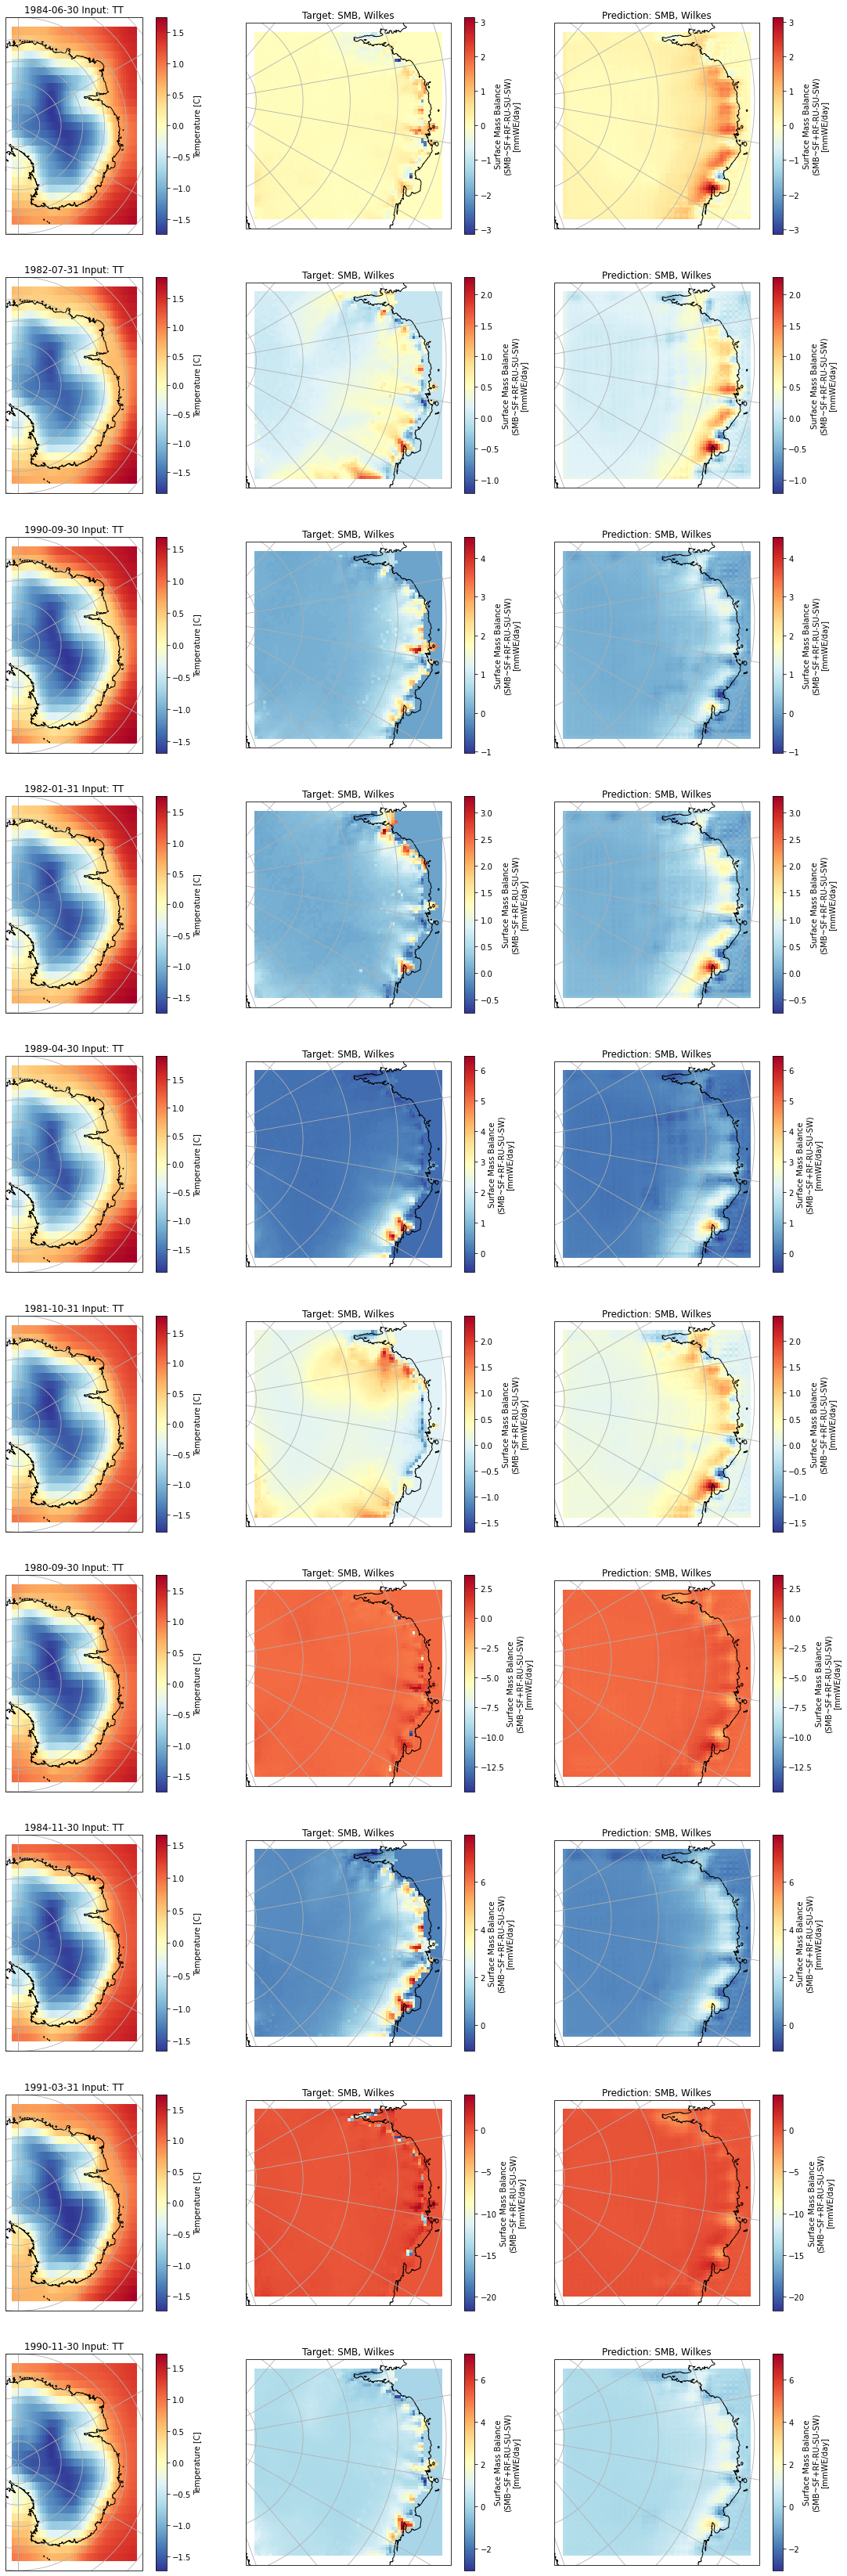

In [ ]:
from training_functions import *

REGION = "Wilkes"

# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds, x, z, true_smb, r = predict(net, device, test_loader, model)
# plot predictions
plotRandomPredictions(
    preds,
    x,
    z,
    true_smb,
    r,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=[REGION],
    **trainingParam
)

/content/metrics.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDepre

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

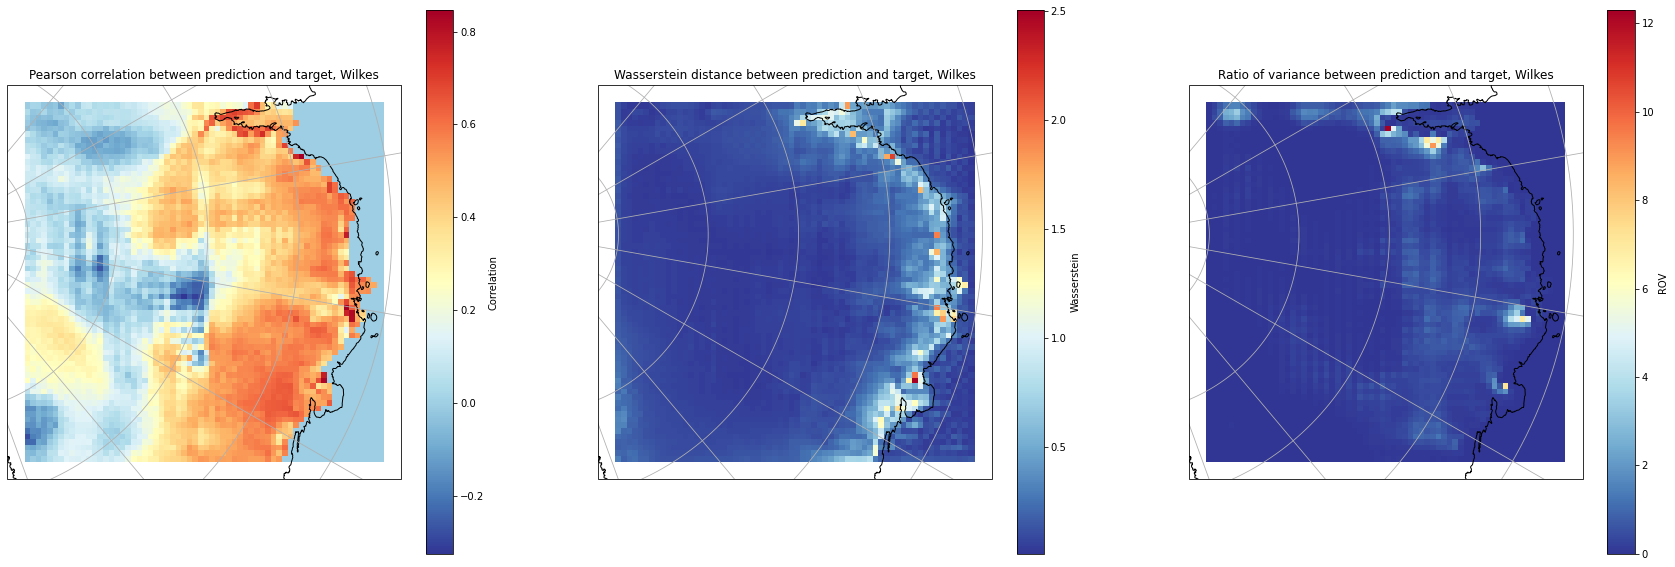

In [ ]:
from metrics import *

fig = plt.figure(figsize=(30, 10))

PearsonCorr = calculatePearson(preds, true_smb)
vmin, vmax = PearsonCorr.min(), PearsonCorr.max()
ax = plt.subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
plotPearsonCorr(target_dataset, PearsonCorr, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
Wasserstein = calculateWasserstein(preds, true_smb)
vmin, vmax = Wasserstein.min(), Wasserstein.max()
plotWasserstein(target_dataset, Wasserstein, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
ROV = calculateROV(preds, true_smb)
vmin, vmax = ROV.min(), ROV.max()
plotROV(target_dataset, ROV, ax, vmin, vmax, region=REGION)

nameFig = f"{today}_metrics_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.png"
plt.savefig(nameFig)
files.download(nameFig)

#### Amundsen:

In [ ]:
REGION ='Amundsen'
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

NUM_EPOCHS = 200
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)

In [ ]:
%%time
train_loss_e, val_loss_e, train_set, test_set = trainFlow(full_input, 
                                     full_target,
                                     region = REGION,
                                     train = True,
                                     **trainingParam)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          200
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/200: 100%|██████████| 1046/1046 [00:09<00:00, 112.94timestep/s, loss (batch)=1.01]
INFO: Checkpoint 1 saved!
Epoch 2/200: 100%|██████████| 1046/1046 [00:08<00:00, 120.53timestep/s, loss (batch)=0.602]
INFO: Checkpoint 2 saved!
Epoch 3/200: 100%|██████████| 1046/1046 [00:08<00:00, 119.30timestep/s, loss (batch)=0.654]

Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.



INFO: Checkpoint 3 saved!
Epoch 4/200: 100%|██████████| 1046/1046 [00:08<00:00, 119.91timestep/s, loss (batch)=0.754]
INFO: Checkpoint 4 saved!
Epoch 5/200:  49%|████▉     | 512/1046 [00:04<00:04, 109.17timestep/s, loss (batch)=0.52] 

Epoch 00049: reducing learning rate of group 0 to 5.0000e-05.


Epoch 5/200: 100%|██████████| 1046/1046 [00:08<00:00, 121.34timestep/s, loss (batch)=0.572]
INFO: Checkpoint 5 saved!
Epoch 6/200: 100%|██████████| 1046/1046 [00:08<00:00, 121.63timestep/s, loss (batch)=0.504]
INFO: Checkpoint 6 saved!
Epoch 7/200: 100%|██████████| 1046/1046 [00:08<00:00, 120.91timestep/s, loss (batch)=0.648]
INFO: Checkpoint 7 saved!
Epoch 8/200: 100%|██████████| 1046/1046 [00:08<00:00, 120.60timestep/s, loss (batch)=0.529]
INFO: Checkpoint 8 saved!
Epoch 9/200: 100%|██████████| 1046/1046 [00:08<00:00, 120.36timestep/s, loss (batch)=0.527]
INFO: Checkpoint 9 saved!
Epoch 10/200: 100%|██████████| 1046/1046 [00:08<00:00, 120.69timestep/s, loss (batch)=0.594]

Epoch 00110: reducing learning rate of group 0 to 5.0000e-06.



INFO: Checkpoint 10 saved!
Epoch 11/200: 100%|██████████| 1046/1046 [00:08<00:00, 121.10timestep/s, loss (batch)=0.76]
INFO: Checkpoint 11 saved!
Epoch 12/200:  15%|█▌        | 160/1046 [00:01<00:06, 138.67timestep/s, loss (batch)=0.559]

Epoch 00122: reducing learning rate of group 0 to 5.0000e-07.


Epoch 12/200:  89%|████████▊ | 928/1046 [00:07<00:00, 130.93timestep/s, loss (batch)=0.466]

Epoch 00130: reducing learning rate of group 0 to 5.0000e-08.


Epoch 12/200: 100%|██████████| 1046/1046 [00:09<00:00, 110.81timestep/s, loss (batch)=0.484]
INFO: Checkpoint 12 saved!
Epoch 13/200:  34%|███▎      | 352/1046 [00:02<00:05, 127.34timestep/s, loss (batch)=0.755]

Epoch 00135: reducing learning rate of group 0 to 5.0000e-09.


Epoch 13/200: 100%|██████████| 1046/1046 [00:08<00:00, 119.08timestep/s, loss (batch)=0.535]
INFO: Checkpoint 13 saved!
Epoch 14/200: 100%|██████████| 1046/1046 [00:08<00:00, 119.63timestep/s, loss (batch)=0.607]
INFO: Checkpoint 14 saved!
Epoch 15/200: 100%|██████████| 1046/1046 [00:08<00:00, 119.02timestep/s, loss (batch)=0.537]
INFO: Checkpoint 15 saved!
Epoch 16/200: 100%|██████████| 1046/1046 [00:08<00:00, 117.87timestep/s, loss (batch)=0.63]
INFO: Checkpoint 16 saved!
Epoch 17/200: 100%|██████████| 1046/1046 [00:08<00:00, 117.62timestep/s, loss (batch)=0.499]
INFO: Checkpoint 17 saved!
Epoch 18/200: 100%|██████████| 1046/1046 [00:08<00:00, 117.49timestep/s, loss (batch)=0.742]
INFO: Checkpoint 18 saved!
Epoch 19/200: 100%|██████████| 1046/1046 [00:08<00:00, 118.22timestep/s, loss (batch)=0.585]
INFO: Checkpoint 19 saved!
Epoch 20/200: 100%|██████████| 1046/1046 [00:08<00:00, 118.01timestep/s, loss (batch)=0.548]
INFO: Checkpoint 20 saved!
Epoch 21/200: 100%|██████████| 1046/1046 

CPU times: user 23min 36s, sys: 14min 19s, total: 37min 55s
Wall time: 38min 45s


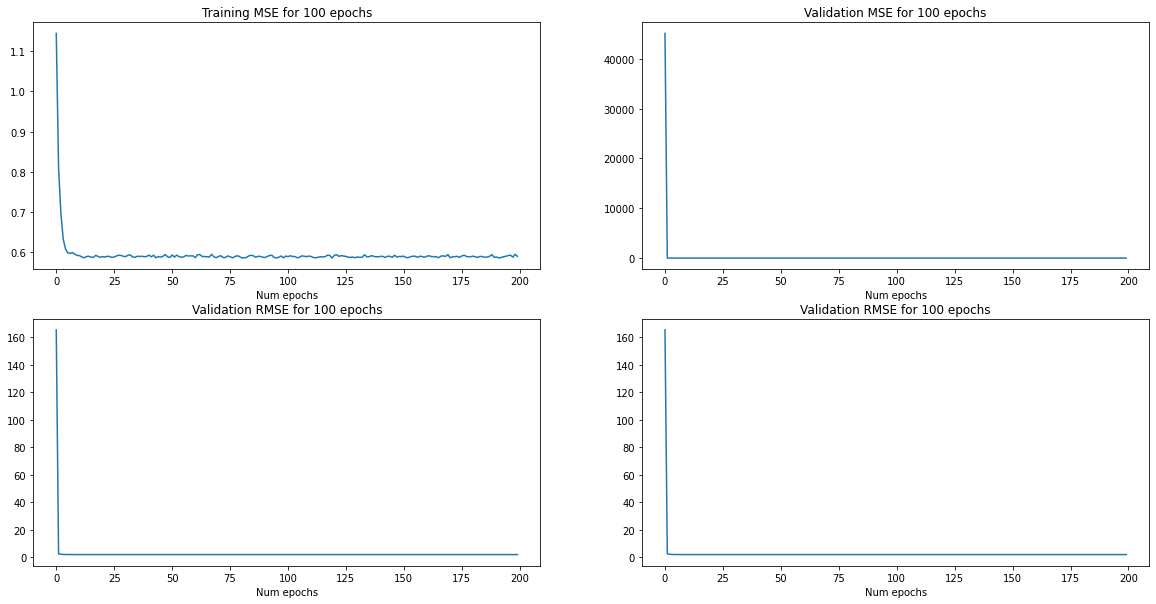

In [ ]:
plotLoss(train_loss_e, val_loss_e)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Amundsen_100_32.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometrie

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

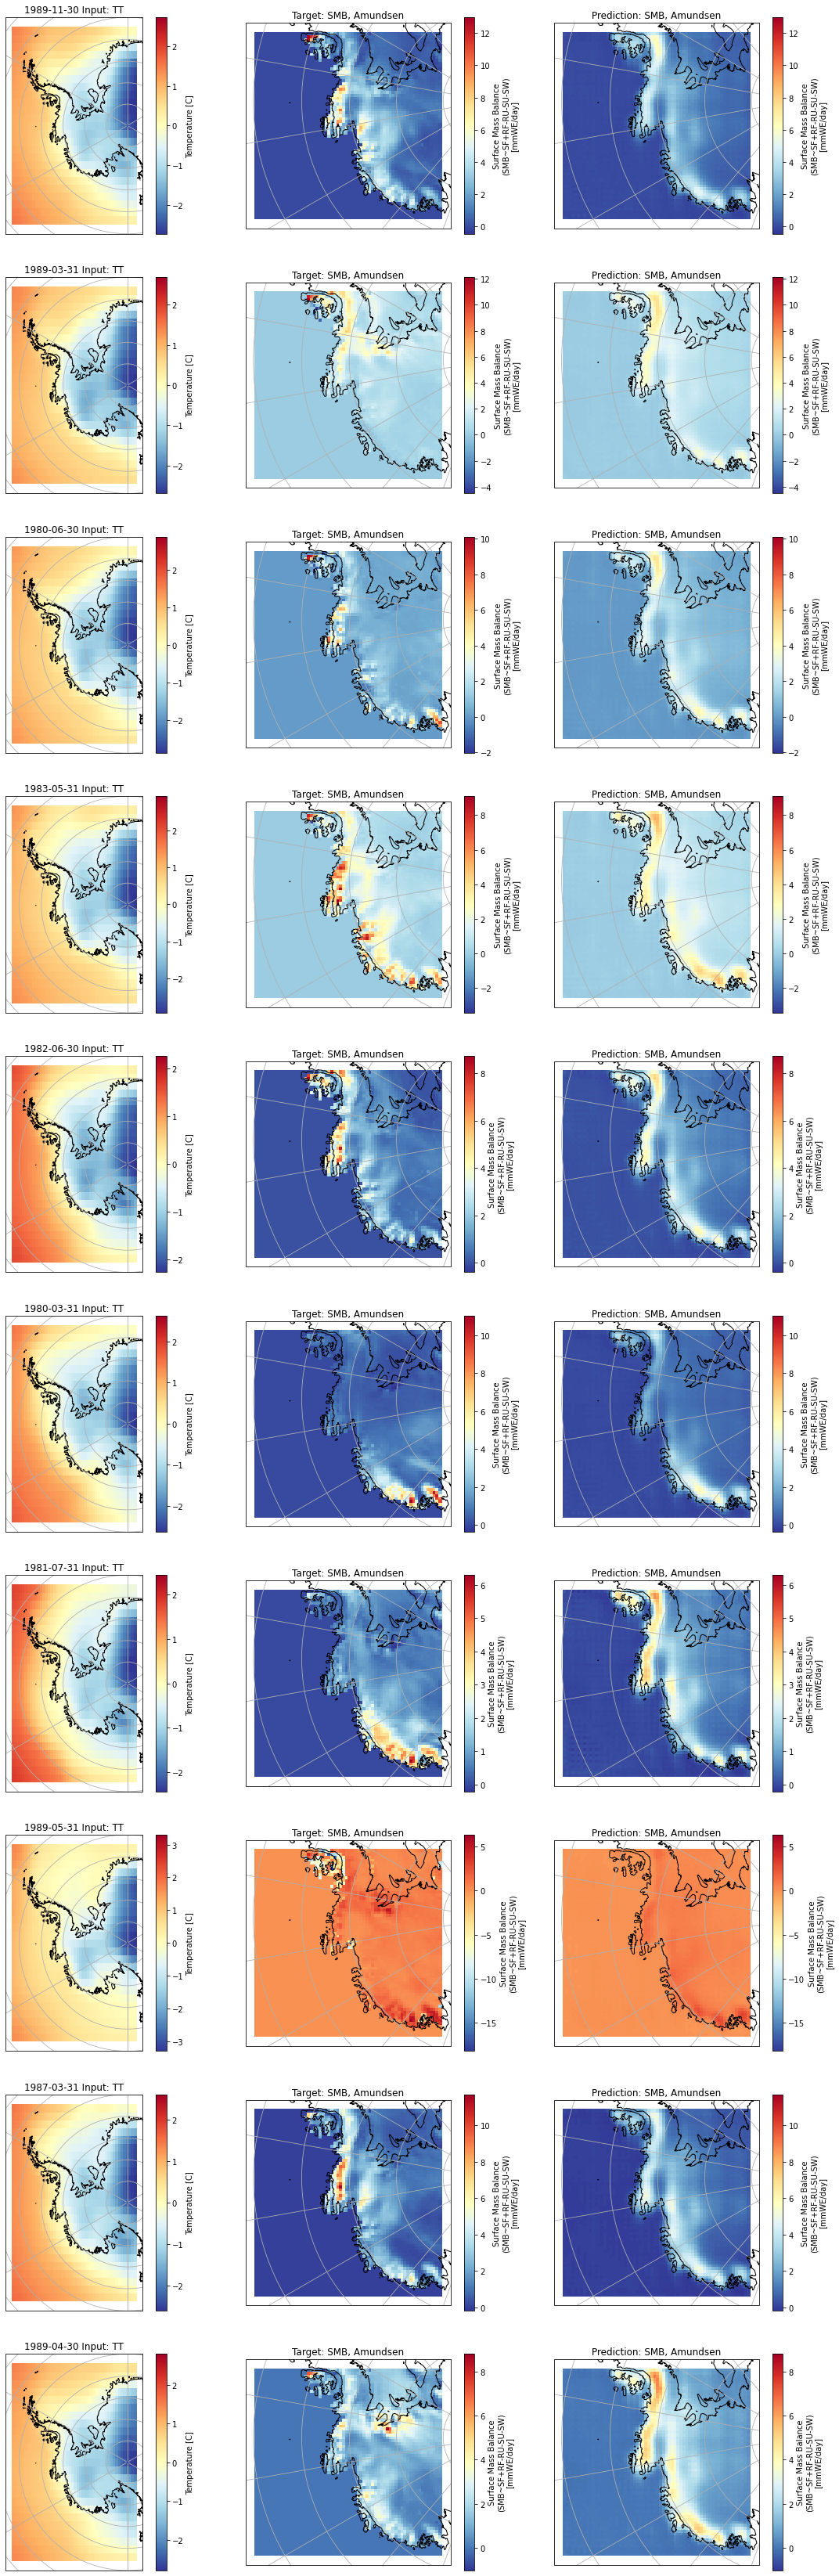

In [ ]:
from training_functions import *

REGION = "Amundsen"

# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
today = str(date.today())
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds, x, z, true_smb, r = predict(net, device, test_loader, model)
# plot predictions
plotRandomPredictions(
    preds,
    x,
    z,
    true_smb,
    r,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=[REGION],
    **trainingParam
)

/content/metrics.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDepre

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

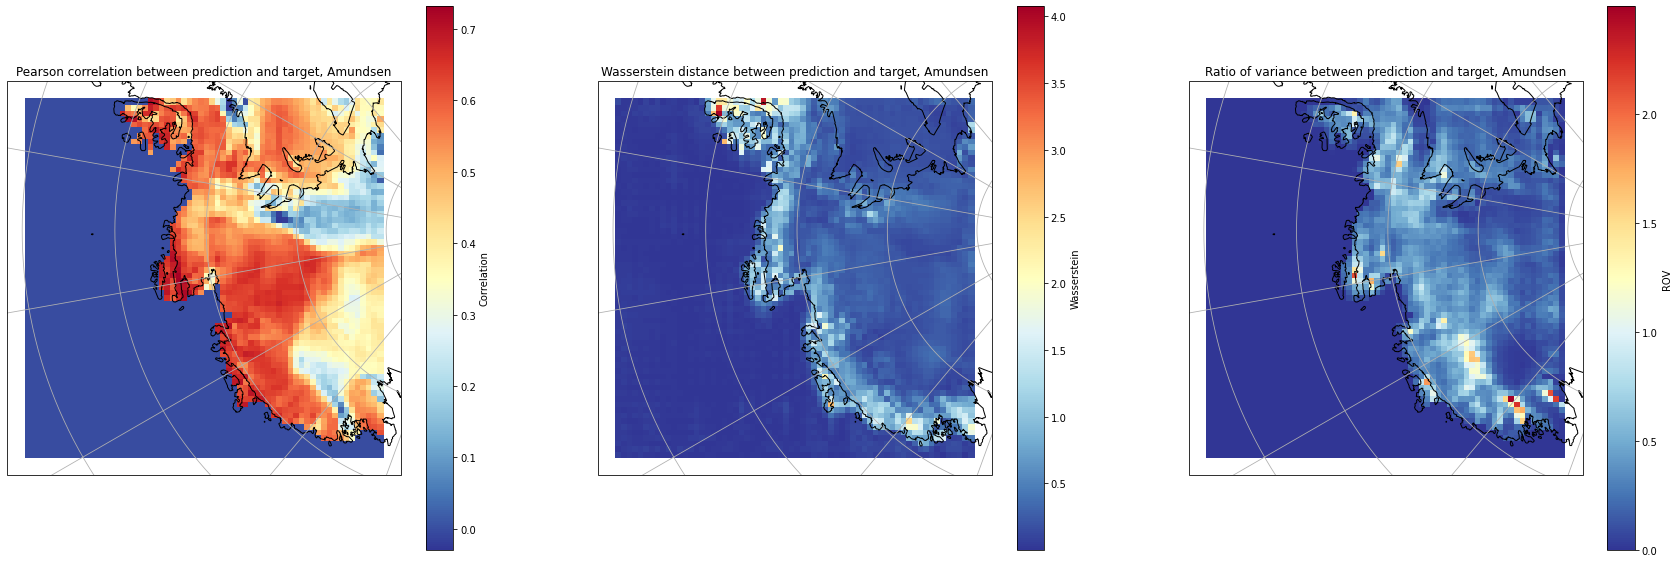

In [ ]:
from metrics import *

fig = plt.figure(figsize=(30, 10))

PearsonCorr = calculatePearson(preds, true_smb)
vmin, vmax = PearsonCorr.min(), PearsonCorr.max()
ax = plt.subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
plotPearsonCorr(target_dataset, PearsonCorr, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
Wasserstein = calculateWasserstein(preds, true_smb)
vmin, vmax = Wasserstein.min(), Wasserstein.max()
plotWasserstein(target_dataset, Wasserstein, ax, vmin, vmax, region=REGION)

ax = plt.subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
ROV = calculateROV(preds, true_smb)
vmin, vmax = ROV.min(), ROV.max()
plotROV(target_dataset, ROV, ax, vmin, vmax, region=REGION)

nameFig = f"{today}_metrics_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.png"
plt.savefig(nameFig)
files.download(nameFig)